In [1]:
#IMPORT LIBRARIES:
import os
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.spatial import distance

In [2]:
#ASSIGN VARIABLES:
# Query image
query_image_path = ''

# Image database
folder_path = ''

# Labels associated with your database
csv_labels = 'CSVFiles/hotelLabels.csv'

# Color histogram data path
csv_histograms = 'CSVFiles/hotelColorHistograms.csv' #This was too large to include in the github repository

# Query all images data path
csv_query = 'CSVFiles/hotelQueryInput.csv'

# Variables used in for-loop. 
# Change if you do not want histogram data for specific methods or color spaces
methods_list = ['euclidean', 'cosine', 'correlation', 'chi2', 'intersection', 'bhattacharyya'] 
color_space_list = ['RGB', 'HSV', 'LAB']

In [3]:
#FUNCTIONS:
# This function calculates the color histogram for images
def calculateHistogram(image, color_space='RGB'):
    if color_space == 'HSV':
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 180, 0, 256, 0, 256])
    elif color_space == 'RGB':
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    elif color_space == 'LAB':
        image = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)
        hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    else: 
        raise ValueError("Unknown method: choose from 'HSV', 'RGB', 'LAB'")
    # Normalize the histogram
    cv2.normalize(hist, hist)
    return hist.flatten()

    
# This functions saves all the color histogram data (RGB, HSV, & CIELAB) into a csv file.
# This is useful for large databases because you only have to "calculate_histogram" for the enitre database once.
# Significantly reduces runtime
def saveHistograms(folder_path, csv_output_path):
    data = []

    for filename in os.listdir(folder_path):
        if filename.endswith((".png", ".jpg", ".jpeg")):
            image_path = os.path.join(folder_path, filename)
            image = cv2.imread(image_path)
            rgb_hist = calculateHistogram(image, color_space='RGB')
            hsv_hist = calculateHistogram(image, color_space='HSV')
            lab_hist = calculateHistogram(image, color_space='LAB')
            data.append([filename, rgb_hist.tolist(), hsv_hist.tolist(), lab_hist.tolist()])

    df = pd.DataFrame(data, columns=['image', 'rgb_histogram', 'hsv_histogram', 'lab_histogram'])
    df.to_csv(csv_output_path, index=False)


#This method loads the color histogram data from the CSV file
def loadHistograms(csv_path):
    df = pd.read_csv(csv_path)
    histograms = {}
    for index, row in df.iterrows():
        filename = row['image']
        rgb_hist = np.array(eval(row['rgb_histogram']), dtype=np.float32)
        hsv_hist = np.array(eval(row['hsv_histogram']), dtype=np.float32)
        lab_hist = np.array(eval(row['lab_histogram']), dtype=np.float32)
        histograms[filename] = {'RGB': rgb_hist, 'HSV': hsv_hist, 'LAB': lab_hist}
    return histograms

# This function loads the appropriate database/query image labels from a CSV (only for labeled databases)
def loadClass(csv_path):
    df = pd.read_csv(csv_path)
    # Ensure that the 'image' column is unique
    if df['image'].duplicated().any():
        raise ValueError("Image names in CSV must be unique")
    labels = df.set_index('image')[['chain', 'hotel_id']].to_dict(orient='index')
    return labels

# This function compares color histograms based on the specified calculation.
def compareHistograms(histA, histB, method):
    if method == 'euclidean':
        return distance.euclidean(histA, histB)
    elif method == 'cosine':
        return distance.cosine(histA, histB)
    elif method == 'chi2':
        return cv2.compareHist(histA.astype('float32'), histB.astype('float32'), cv2.HISTCMP_CHISQR)
    elif method == 'correlation':
        return cv2.compareHist(histA.astype('float32'), histB.astype('float32'), cv2.HISTCMP_CORREL)
    elif method == 'intersection':
        return cv2.compareHist(histA.astype('float32'), histB.astype('float32'), cv2.HISTCMP_INTERSECT)
    elif method == 'bhattacharyya':
        return cv2.compareHist(histA.astype('float32'), histB.astype('float32'), cv2.HISTCMP_BHATTACHARYYA)
    else:
        raise ValueError("Unknown method: choose from 'euclidean', 'cosine', 'chi2', 'correlation', 'intersection', or 'bhattacharyya'")


# This function finds the most similar images
def findImages(query_image_path, k=5, method='euclidean', color_space='RGB', labels=None, histograms=None):
    query_image = cv2.imread(query_image_path)
    query_hist = calculateHistogram(query_image, color_space)
    query_image_name = os.path.basename(query_image_path)

    #Check if histograms were added
    if histograms == None:
        distances = {}
        for filename in os.listdir(folder_path):
            if filename.endswith((".png", ".jpg", ".jpeg")) and filename != query_image_name:
                image_path = os.path.join(folder_path, filename)
                image = cv2.imread(image_path)
                hist = calculateHistogram(image, color_space)
                dist = compareHistograms(query_hist, hist, method)
                distances[image_path] = dist
    else:
        distances = {}
        for filename, hists in histograms.items():
            if filename != query_image_name:
                hist = hists[color_space]
                dist = compareHistograms(query_hist, hist, method)
                distances[filename] = dist

    if method in ['correlation', 'intersection']:
        sorted_distances = sorted(distances.items(), key=lambda item: item[1], reverse=True)
    else:
        sorted_distances = sorted(distances.items(), key=lambda item: item[1])
        
    top_k_images = sorted_distances[:k]

    # Count how many of the top-k images belong to the same first and second classes as the query image
    same_first_class_count = 0
    same_second_class_count = 0
    query_labels = labels.get(query_image_name, {"chain": "Unknown", "hotel_id": "Unknown"})
    if labels and query_labels is not None:
        for filename, _ in top_k_images:
            image_labels = labels.get(filename, {"chain": "Unknown", "hotel_id": "Unknown"})
            if image_labels['chain'] == query_labels['chain']:
                same_first_class_count += 1
            if image_labels['hotel_id'] == query_labels['hotel_id']:
                same_second_class_count += 1

    return top_k_images, same_first_class_count, same_second_class_count, query_labels


# This function displays the Top-K images retrieved 
def displayImages(query_image_path, top_images, chain_count, id_count, query_labels, labels):
    fig, axes = plt.subplots(1, len(top_images) + 1, figsize=(15, 5))
    
    # Display query image
    query_image = cv2.imread(query_image_path)
    axes[0].imshow(cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB))
    axes[0].set_title(f"Query Image\nChain: {query_labels['chain']}\nHotel ID: {query_labels['hotel_id']}")
    axes[0].axis('off')

    for i, (image_path, dist) in enumerate(top_images):
        image_path = os.path.join(folder_path, image_path)
        image = cv2.imread(image_path)
        if image is not None:
            axes[i+1].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            filename = os.path.basename(image_path)
            image_labels = labels.get(filename, {"chain": "Unknown", "hotel_id": "Unknown"})
            title = f"{filename}\nChain: {image_labels['chain']}\nHotel ID: {image_labels['hotel_id']}\nDist: {dist:.2f}"
            axes[i+1].set_title(title)
        else:
            axes[i+1].set_title('Image not found')
        axes[i+1].axis('off')

    plt.tight_layout()
    plt.show()
    
    same_chain = (chain_count / len(top_images)) * 100
    same_id = (id_count / len(top_images)) * 100
    print(f'  In the retrieved images, {same_chain}% belong to the same hotel chain as the query image')
    print(f'  In the retrieved images, {same_id}% belong to the same hotel branch as the query image')

# This function tests multiple query images for their Top-K retrieval accuracy
# Prints data to CSV
def queryAllImages(csv_labels, folder_path, csv_query):
    data = []
    df = pd.read_csv(csv_labels)
    for filename in df['image']:
        image_path = os.path.join(folder_path, filename)
        for method in methods_list:
            for space in color_space_list: 
                results = findImages(image_path, k=5, method=method, color_space=space, labels=labels, histograms=histograms)
                chain_accuracy = results[1]
                id_accuracy = results[2]
                data.append([filename, chain_accuracy, id_accuracy, method, space])
    
    df = pd.DataFrame(data, columns=['image', 'chain_accuracy', 'id_accuracy', 'method', 'color_space'])
    df.to_csv(csv_query, index=False)

In [6]:
# Load image classes from csv
labels = loadClass(csv_labels)
histograms = loadHistograms(csv_histograms)

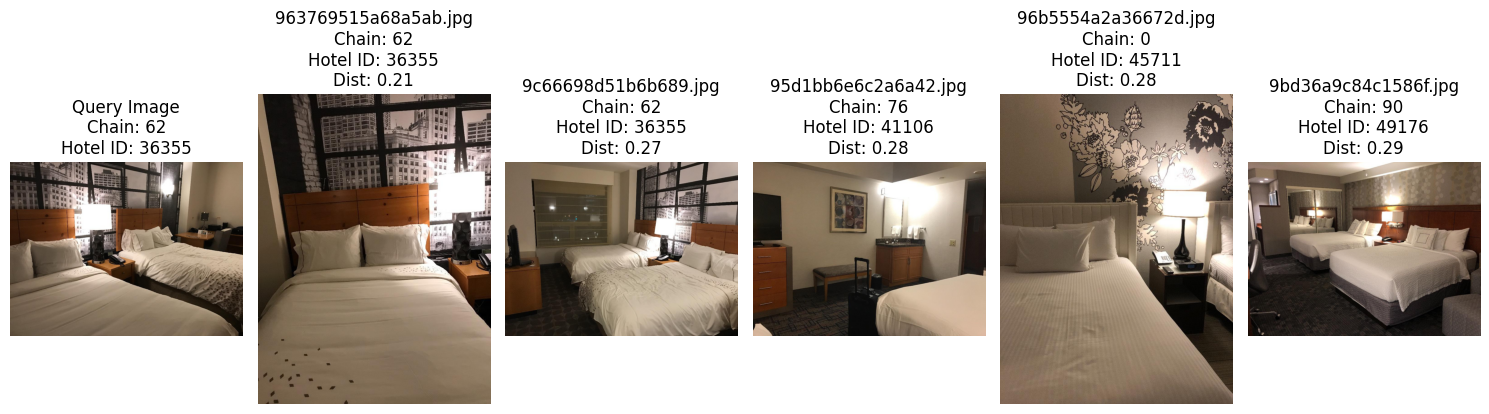

  In the retrieved images, 40.0% belong to the same hotel chain as the query image
  In the retrieved images, 40.0% belong to the same hotel branch as the query image


In [8]:
#CALL IF YOUR DATABASE IS SMALL (<1000) or if 'histograms' is used:
# Print out TOP-K retreived images
top_images, same_chain, same_hotel_id, query_labels = findImages(query_image_path, k=5, method='bhattacharyya', color_space='HSV', labels=labels, histograms=histograms) 
displayImages(query_image_path, top_images, same_chain, same_hotel_id, query_labels, labels)


In [ ]:
# CALL IF YOUR DATABASE IS LARGE (>1000) (ONCE):
# Extracts the histograms from your database and outputs them into csv_histograms
saveHistograms(folder_path, csv_histograms)

#CALL ONLY TO TEST ACCURACY of color space and equation combinations
# Query all images (For Accuracy Testing), output results to 'csv_query'. Query only some images by editing "csv_labels"
queryAllImages(csv_labels, folder_path, csv_query)